# Tracing Workflows with Langfuse

This notebook demonstrates how to gain real-time observability for your [LlamaIndex Workflows](https://docs.llamaindex.ai/en/stable/module_guides/workflow/) by ingesting traces to [Langfuse](https://github.com/langfuse/langfuse).

## Step 1: Install Dependencies

In [ ]:
%pip install langfuse llama-index-workflows openinference-instrumentation-llama_index llama-index-instrumentation

# Optional if using openai or other llama-index packages
%pip install llama-index-llms-openai

## Step 2: Set Up Environment Variables

Configure your Langfuse API keys. You can get them by signing up for [Langfuse Cloud](https://cloud.langfuse.com) or [self-hosting Langfuse](https://langfuse.com/self-hosting).

In [6]:
import os

# Your openai key
os.environ["OPENAI_API_KEY"] = "sk-proj-..."

With the environment variables set, we can now initialize the Langfuse client.

In [ ]:
from langfuse import Langfuse

langfuse = Langfuse(
    secret_key="sk-lf-...", public_key="pk-lf-...", host="https://us.cloud.langfuse.com"
)

# Verify connection
if langfuse.auth_check():
    print("Langfuse client is authenticated and ready!")
else:
    print("Authentication failed. Please check your credentials and host.")

Langfuse client is authenticated and ready!


## Step 3: Initialize LlamaIndex Instrumentation

Now, we initialize the [OpenInference LlamaIndex instrumentation](https://docs.arize.com/phoenix/tracing/integrations-tracing/llamaindex). This third-party instrumentation automatically captures LlamaIndex operations and exports OpenTelemetry (OTel) spans to Langfuse.

In [8]:
from openinference.instrumentation.llama_index import LlamaIndexInstrumentor

# Initialize LlamaIndex instrumentation
LlamaIndexInstrumentor().instrument()

## Step 4: Create a Simple LlamaIndex Workflows Application

In LlamaIndex Workflows, you build event-driven AI agents by defining steps with the `@step` decorator. Each step processes an event and, if appropriate, emits new events.

In [12]:
from llama_index.core.llms import ChatMessage
from llama_index.llms.openai import OpenAI
from typing import Annotated

from workflows import Workflow, step
from workflows.events import StartEvent, StopEvent
from workflows.resource import Resource


def get_llm():
    return OpenAI(model="gpt-4.1-mini")


class MyWorkflow(Workflow):
    @step
    async def step1(
        self, ev: StartEvent, llm: Annotated[OpenAI, Resource(get_llm)]
    ) -> StopEvent:
        message = ChatMessage(role="user", content=ev.get("input"))
        response = await llm.achat([message])
        return StopEvent(result=response.message.content)


wf = MyWorkflow()

In [ ]:
response = await wf.run(input="Hi there!")
print(response)

Hello! How can I assist you today?


## Step 5: View Traces in Langfuse

After running your workflow, open [Langfuse](https://cloud.langfuse.com) to explore the generated traces. You will see logs for each workflow step along with metrics such as token counts, latencies, and execution paths. 

![Langfuse Trace Example](https://langfuse.com/images/cookbook/integration-llamaindex-workflows/llamaindex-workflows-example-trace.png)

_[Public example trace in Langfuse](https://cloud.langfuse.com/project/cloramnkj0002jz088vzn1ja4/traces/e0987dce85c8c49602030599b84e77e8?timestamp=2025-07-01T09%3A42%3A54.701Z&display=details)_

## References

- [LlamaIndex Workflows documentation](https://docs.llamaindex.ai/en/stable/module_guides/workflow/)  
- [Adding additional trace attributes](https://langfuse.com/docs/integrations/llama-index/workflows#interoperability-with-the-python-sdk)

# (Optional) Step 6: Adding Custom Spans and Events

Using the `llama-index-instrumentation` package, you can add custom spans and events to your workflow!

In [15]:
from llama_index_instrumentation import get_dispatcher
from llama_index_instrumentation.base import BaseEvent

dispatcher = get_dispatcher()


class MyEvent(BaseEvent):
    data: str


@dispatcher.span
def my_span(data: str) -> None:
    dispatcher.event(MyEvent(data=data))
    print(data)

Since workflows are automatically instrumented, any custom events and spans will be automatically captured and ingested into Langfuse as a workflow runs!

In [16]:
from llama_index.llms.openai import OpenAI
from typing import Annotated

from workflows import Workflow, step
from workflows.events import StartEvent, StopEvent
from workflows.resource import Resource


def get_llm():
    return OpenAI(model="gpt-4.1-mini")


class MyWorkflow(Workflow):
    @step
    async def step1(
        self, ev: StartEvent, llm: Annotated[OpenAI, Resource(get_llm)]
    ) -> StopEvent:
        message = ChatMessage(role="user", content=ev.get("input"))
        response = await llm.achat([message])

        # This will create a custom span and event in Langfuse
        my_span("This is a custom span")

        return StopEvent(result=response.message.content)


wf = MyWorkflow()
response = await wf.run(input="Hi there!")
print(response)

This is a custom span
Hello! How can I assist you today?


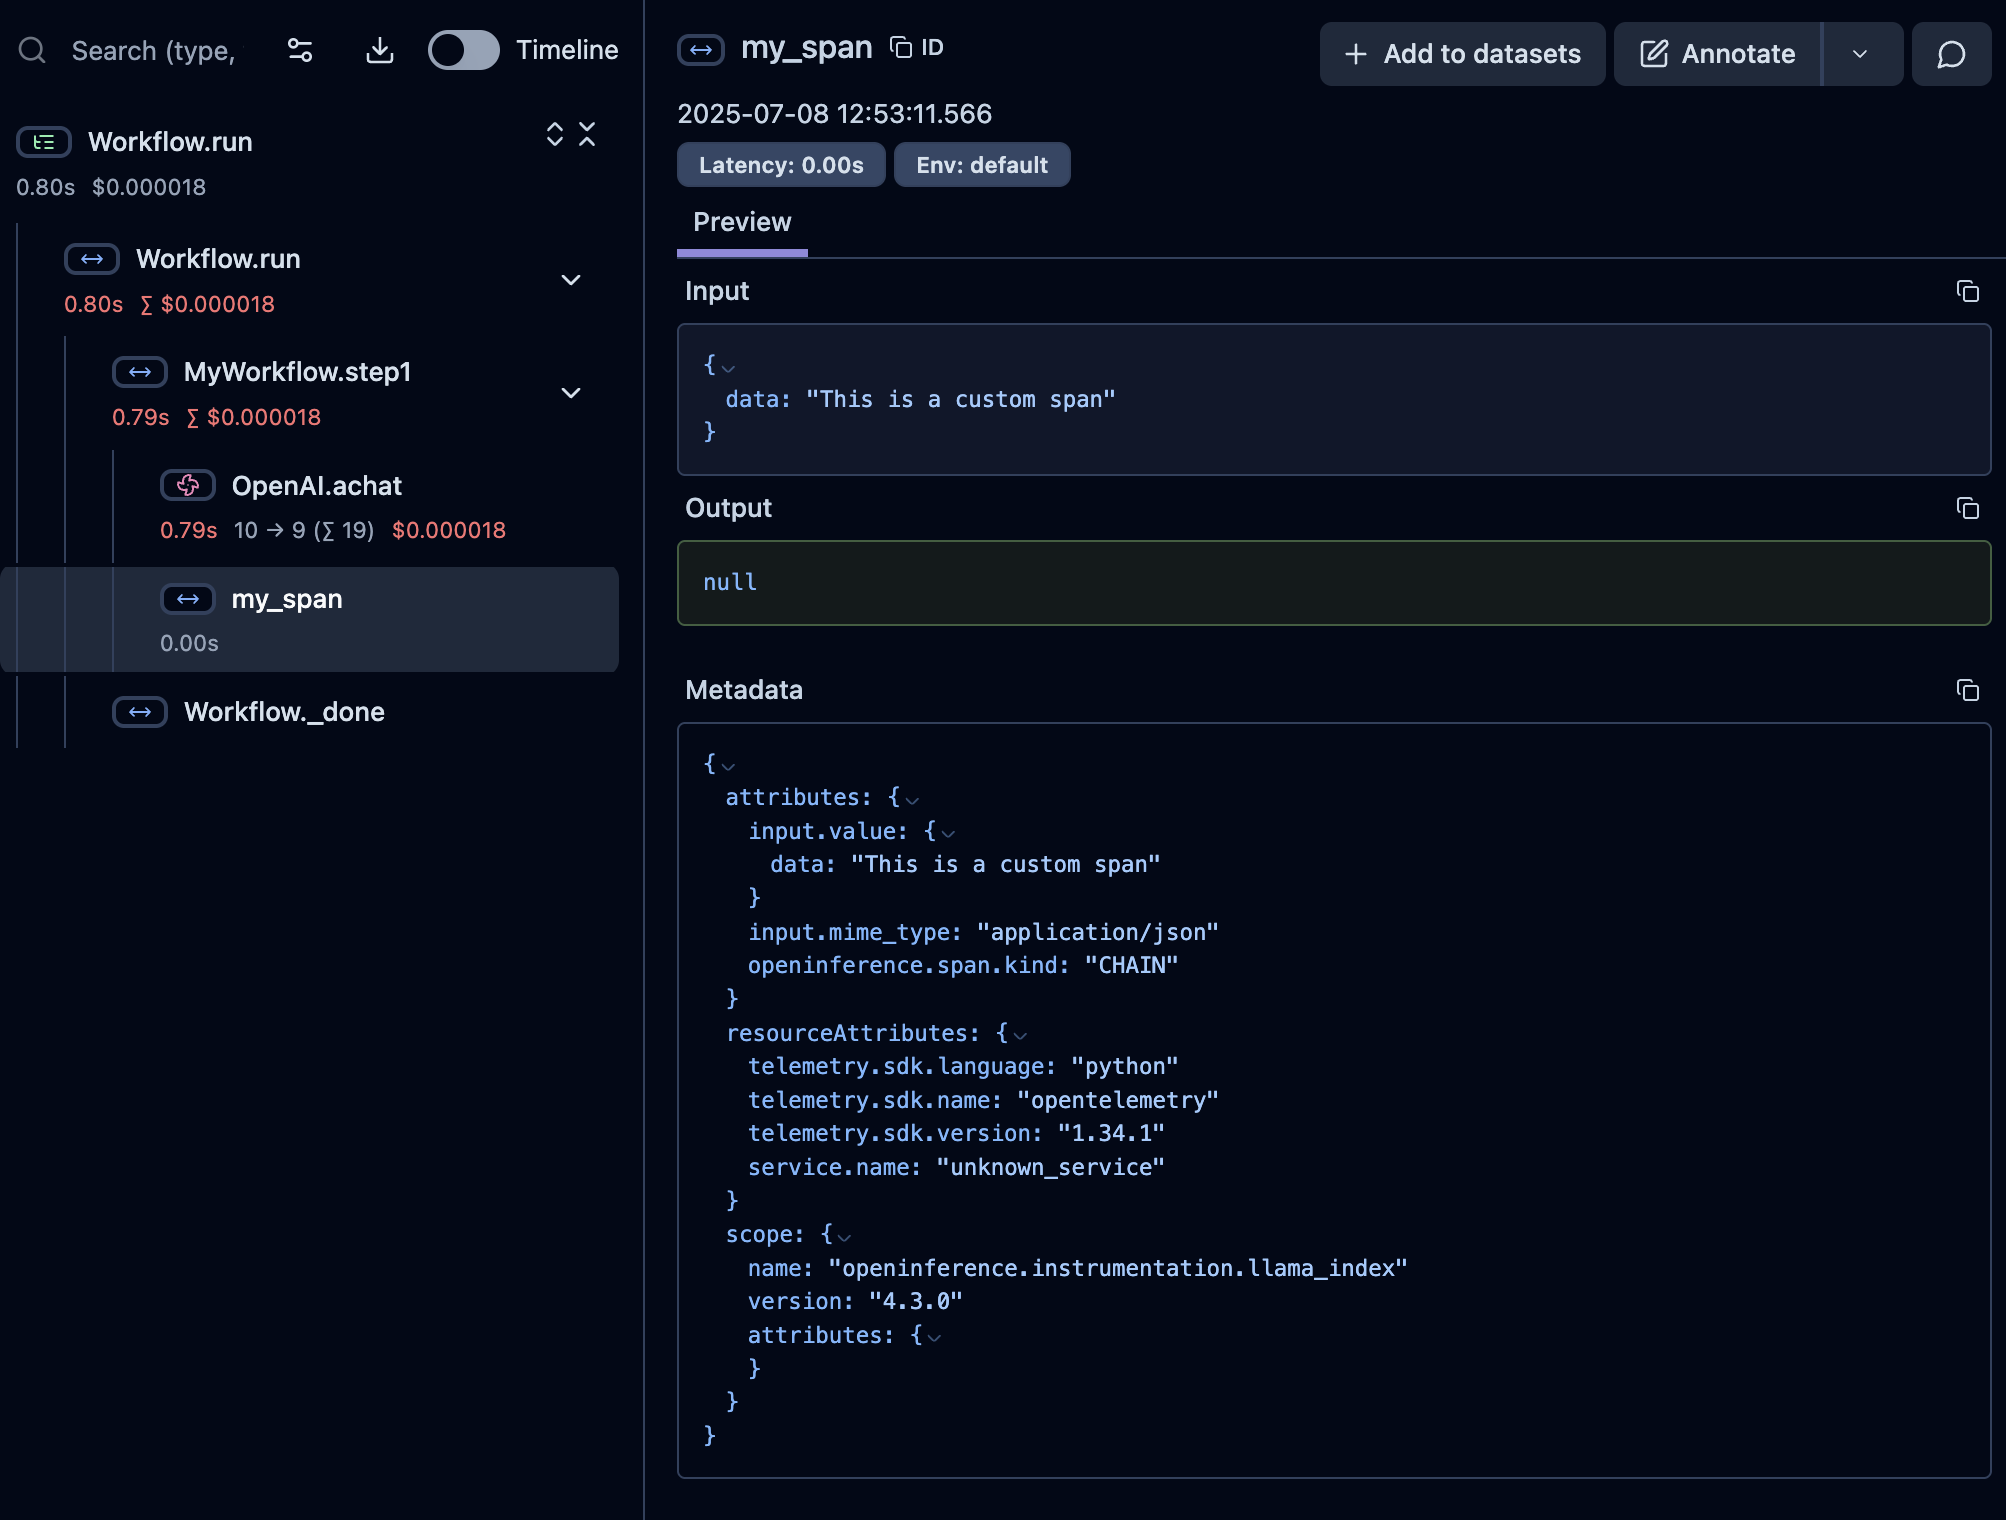